In [2]:
import pandas as pd
import glob
i=0
for player in glob.glob("data/singles/*.parquet"):
    print(player)
    df = pd.read_parquet(player)
    if "playerWinnerCode" in df.columns:
        if "0" in df.playerWinnerCode.values:
            print(df.playerWinnerCode)
    if i>15:
        break
    i += 1

data/singles/Romain*Blättler_competitionValuePrev=4.025__competitionValue=3.962.parquet
data/singles/Dimo*Hristov_competitionValuePrev=3.043__competitionValue=3.235.parquet
data/singles/Thomas*Tekeste_competitionValuePrev=4.16__competitionValue=4.697.parquet
data/singles/Patrick*Waldmeier_competitionValuePrev=4.543__competitionValue=4.274.parquet
data/singles/Martin*Vuichard_competitionValuePrev=4.014__competitionValue=3.328.parquet
data/singles/Richard*Ekwall_competitionValuePrev=4.765__competitionValue=4.929.parquet
data/singles/Cédric*Rognon_competitionValuePrev=4.592__competitionValue=4.61.parquet
data/singles/Nicolò*Canova_competitionValuePrev=6.052__competitionValue=6.22.parquet
data/singles/Mauro*Baumann_competitionValuePrev=3.385__competitionValue=3.465.parquet
data/singles/Jakub*Krawetkowski_competitionValuePrev=3.572__competitionValue=3.684.parquet
data/singles/Remo*Cavegn_competitionValuePrev=4.367__competitionValue=4.463.parquet
data/singles/Jelle*van*Waardenburg_competitio

In [3]:
"""Ranking algorithm implementation based on Art. 5 (Swiss Table‑Tennis regulations)
===========================================================================

*Version 2 – fixes KeyError in the loss‑discard routine.*

This module processes **one parquet file per player** and computes the final
ranking value **C**.  The player’s initial **W₅** is parsed from the file name
pattern:

    <First>-<Last>_competitionValue=<W5>.parquet

Example: ``Daniel-Graf_competitionValue=6.52.parquet`` gives
``firstname = Daniel``, ``lastname = Graf``, ``W5 = 6.52``.

Run from the command line::

    python ranking_algorithm.py \
        --results_dir ./parquets \
        --output_csv rankings.csv

It prints (or writes) a table with **W**, **R**, and **C** rounded to three
decimals.
"""

from __future__ import annotations

import argparse
import glob
import os
import re
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------------------------------------------------------------------------
# Helper functions
# ---------------------------------------------------------------------------
MAX_IGNORED_LOSSES=4


def _log_sum_exp(values: List[float]) -> float:
    """Numerically stable ``log(sum(exp(values)))`` computation."""
    if not values:
        return float("-inf")  # log(0) when the list is empty
    m = float(np.max(values))
    # return m + float(np.log(np.sum(np.exp(np.array(values) - m))))
    return float(np.log(np.sum(np.exp(np.array(values)))))

def _disregard_loss_mask(df: pd.DataFrame) -> pd.Series:
    # Identify losses
    mask = pd.Series(False, index=df.index)
    
    if len(df) < 6:
        # If there are fewer than 6 matches, no losses are disregarded
        return mask
    
    losses = df[df['playerWinnerCode'] == 'N']
    
    # Number of losses to disregard: floor(len(df) / 6), capped at 4
    num_to_disregard = min(len(df) // 6, 4)
    
    if num_to_disregard == 0 or losses.empty:
        return pd.Series(False, index=df.index)
    
    # Get indices of losses with the lowest competitionValue4L
    losses_to_ignore = losses.nsmallest(num_to_disregard, 'adversary.competitionValue4L')
    
    # Create boolean mask
    mask.loc[losses_to_ignore.index] = True
    
    return mask


def _compute_W_R(
    df: pd.DataFrame,
    w0: float,
    opponent_values: Dict[Tuple[str, str], float],
    print_debug:bool=False,
) -> Tuple[float, float]:
    """Calculate **W** and **R** for a single player.

    The ambiguity error observed earlier happens when the DataFrame index is
    non‑unique, making ``ignore_loss.at[idx]`` return a *Series* instead of a
    scalar.  We therefore switch to **positional** lookup (``iat``) which is
    immune to duplicate index labels.
    """
    ignore_loss = _disregard_loss_mask(df)  # positional mask

    wins, losses = [], []
    for pos, (_, row) in enumerate(df.iterrows()):
        code = row["playerWinnerCode"]
        opp_key = (row["adversaryFirstname"], row["adversaryLastname"])
        w_opp = opponent_values.get(opp_key, row["adversary.competitionValue4L"])
        if code == "S":
            wins.append(w_opp)
        elif code == "N" and not ignore_loss.iat[pos]:
            losses.append(w_opp)
        if print_debug:
            print(f"{code = }, {opp_key = }, {w_opp = }, {ignore_loss.iat[pos] = }")
            
        # Codes "0" (opponent absent) and "1" (player absent) do not influence W/R.
    if print_debug:
        print(f"{(wins) = }") 
        print(f"{(losses) = }")
        print(f"{ignore_loss = }")
             
    term_pos = _log_sum_exp([w0] + wins)
    term_neg = _log_sum_exp([-w0] + [-w for w in losses])

    W = 1 / 2.0 * (term_pos - term_neg)
    R = 1 / 6.0 * (term_pos + term_neg)
    if print_debug:
        print(f"Computed W={W}, R={R} for w0={w0}")
    return W, R




In [60]:
end_date= pd.to_datetime("2025-05-01")
results_dir = "data/singles"
"""Compute **W**, **R**, and **C** for every parquet in *results_dir*."""
# 1️⃣ Load parquet files and derive (firstname, lastname, w0)
player_dfs: Dict[Tuple[str, str], pd.DataFrame] = {}
w0_map: Dict[Tuple[str, str], float] = {}
w0_prev_map: Dict[Tuple[str, str], float] = {}

fname_rx = re.compile(
    r"^(?P<name>.+?)_competitionValuePrev=.*_competitionValue=(?P<val>[+-]?[0-9]*\.?[0-9]+)$"
)
fname_rx_prev = re.compile(
    r".*_competitionValuePrev=(?P<val>[+-]?[0-9]*\.?[0-9]+)_.*"
)

for path in tqdm(glob.glob(os.path.join(results_dir, "*.parquet"))):
    base = os.path.splitext(os.path.basename(path))[0]
    m = fname_rx.match(base)
    m_prev = fname_rx_prev.match(base)
    if not m or not m_prev:
        raise ValueError(
            f"Filename does not match '<First>-<Last>_competitionValue=<val>.parquet': {base}"
        )
    name_part, val_part = m.group("name"), m.group("val")
    val_part_prev = m_prev.group("val")
    # Accept dash or underscore between first and last names
    sep = "*"
    first, last = name_part.split(sep, 1)
    key = (first, last)
    w0_map[key] = float(val_part)
    w0_prev_map[key] = float(val_part_prev)
    df=pd.read_parquet(path)
    if len(df)>0:
        player_dfs[key] = df[df.index < end_date] 
    else:
        player_dfs[key] = df

100%|██████████| 13255/13255 [00:55<00:00, 237.50it/s]


In [5]:
key=("Leonard","Ung")
print(f"w0_map[{key}] = {w0_map[key]}")
print(f"w0_prev_map[{key}] = {w0_prev_map[key]}")

w0_map[('Leonard', 'Ung')] = 6.967
w0_prev_map[('Leonard', 'Ung')] = 6.853


In [ ]:
comp_values = {k: w0_prev_map[k] for k in w0_prev_map}

for _ in range(1):
    next_values: Dict[Tuple[str, str], float] = {}
    for key, df in tqdm(player_dfs.items(), desc="Computing W"):
        W, _ = _compute_W_R(df, w0_prev_map[key], comp_values, print_debug=key==("Leonard","Ung"))
        next_values[key] = W
    comp_values = next_values


Computing W:  18%|█▊        | 2334/13081 [00:02<00:16, 666.72it/s]

code = 'N', opp_key = ('Ruben', 'Fernandez'), w_opp = 6.1266, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Olivier', 'Pifferini'), w_opp = 4.6074, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Adrian', 'Saliaj'), w_opp = 6.734, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Luca', 'Barlocchi'), w_opp = 6.532500000000001, ignore_loss.iat[pos] = np.True_
code = 'N', opp_key = ('Carlos José', 'Cuevas Guzman'), w_opp = 10.456, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Suriya', 'Stauffer'), w_opp = 6.842099999999999, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Eric', 'Borter'), w_opp = 8.2155, ignore_loss.iat[pos] = np.False_
(wins) = [4.6074, 6.734, 6.842099999999999]
(losses) = [6.1266, 10.456, 8.2155]
ignore_loss = date
2025-03-23 00:00:00.000    False
2025-03-23 00:00:00.000    False
2025-03-23 00:00:00.000    False
2024-06-08 15:34:14.249     True
2024-05-25 12:00:00.000    False
2024-05-11 12:00:00.000    False
2024-05-05 12

Computing W: 100%|██████████| 13081/13081 [00:28<00:00, 455.94it/s]


In [ ]:
from functools import partial
from multiprocessing import Pool, cpu_count
from scipy import optimize
from tqdm.auto import tqdm

# ------------------------------------------------------------------
# 1.  Fix everything that is *shared* across players just once
# ------------------------------------------------------------------
comp_values = {
    k: w0_map[k]  # <- we already know the final W’s
    for k in w0_map
}  #    so use them as the comparison set


# ------------------------------------------------------------------
# 2.  Define the per-player root-finding task
# ------------------------------------------------------------------
def _invert_w0(key_df_target):
    """
    Finds the w0 that makes _compute_W_R(..).W match the stored value.
    Returns (player_key, solved_w0) so it slots straight into a dict().
    """
    key, (df, target_W) = key_df_target

    # helper: zero-residual when we’ve matched the target
    def residual(w0):
        W, _ = _compute_W_R(df, w0, comp_values, print_debug=False)
        return W - target_W

    # ---- fast, derivative-free bracketed method ------------------
    # If _compute_W_R is monotone in w0, give a wide but finite bracket
    # (adjust the bounds if you know a sensible range for w0’s).
    try:
        w0_star = optimize.brentq(residual, 0.0, 1.0, maxiter=50)
    except ValueError:
        # fallback: start Newton at previous value if bracketing fails
        w0_star = optimize.newton(residual, w0_prev_map[key], maxiter=30)

    return key, w0_star


# ------------------------------------------------------------------
# 3.  Launch the work in parallel
# ------------------------------------------------------------------
targets = {k: (player_dfs[k], w0_map[k]) for k in player_dfs}

with Pool(processes=cpu_count()) as pool:
    iterator = pool.imap_unordered(_invert_w0, targets.items(), chunksize=200)
    w0_solution_map = dict(tqdm(iterator, total=len(targets), desc="Solving inverted w0"))

# w0_solution_map now holds the “which-w0-produced-that-W” answer


/home/lung/.pyenv/versions/3.11.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Solving inverted w0: 100%|██████████| 13081/13081 [02:09<00:00, 101.27it/s]


In [67]:
len(w0_solution_map)
len(w0_map)

13081

In [77]:
from matplotlib import pyplot as plt
w_true_list, w0_solution_list= [], []
n_win, n_loss=[],[]
n_matches = []
for key in w0_map:
    w_true_list.append(w0_map[key])
    w0_solution_list.append(w0_solution_map[key])
    n_matches.append(len(player_dfs[key]))
    if player_dfs[key].empty:
        n_win.append(0)
        n_loss.append(0)
    else:
        n_win.append(player_dfs[key]['playerWinnerCode'].value_counts().get('S', 0))
        n_loss.append(player_dfs[key]['playerWinnerCode'].value_counts().get('N', 0))
        


len(df) = 3233
Pearson correlation = 0.998


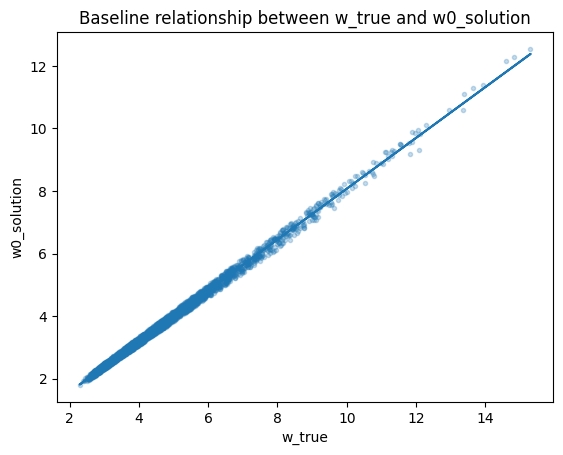

In [131]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "w_true":       w_true_list,
    "w0_solution":  w0_solution_list,
    "n_win":        n_win,
    "n_loss":       n_loss,
    "n_matches":    n_matches
})
# remove all rows where w_true devided by w0_solution < 1 and w_true devided by w0_solution > 1.5
df= df[(df["w_true"] / df["w0_solution"] >= 1.2) & (df["w_true"] / df["w0_solution"] <= 1.3)]
print(f"{len(df) = }")

# Quick sanity-check
assert not df.isna().any().any(), "Missing values will break regressions"
r = np.corrcoef(df["w_true"], df["w0_solution"])[0, 1]
print(f"Pearson correlation = {r:.3f}")
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

X = df[["w_true"]].values
y = df["w0_solution"].values

lin1 = LinearRegression().fit(X, y)
plt.scatter(df["w_true"], df["w0_solution"], alpha=0.25, marker=".")
plt.plot(X, lin1.predict(X))
plt.xlabel("w_true")
plt.ylabel("w0_solution")
plt.title("Baseline relationship between w_true and w0_solution")
plt.show()



In [132]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

predictors = ["w_true", "n_win", "n_loss", "n_matches"]         
# predictors = ["w_true", "n_matches"]         
X_train, X_test, y_train, y_test = train_test_split(
    df[predictors], df["w0_solution"], test_size=0.2, random_state=2)
X_train, X_test, y_train, y_test=df[predictors],df[predictors], df["w0_solution"], df["w0_solution"]
lin = LinearRegression().fit(X_train, y_train)

print("Coefficients (β):", dict(zip(predictors, lin.coef_)))
print("Intercept (β₀):",  lin.intercept_)
print("R² (train / test):",
      f"{lin.score(X_train, y_train):.3f} / {lin.score(X_test, y_test):.3f}")
print("RMSE (test):", np.sqrt(mean_squared_error(y_test, lin.predict(X_test))))
print("Mean absolute percentage error (test):",
        np.mean(np.abs((y_test - lin.predict(X_test)) / y_test)) * 100)


Coefficients (β): {'w_true': np.float64(0.8216067867475123), 'n_win': np.float64(0.003694203833762636), 'n_loss': np.float64(0.007223126940148209), 'n_matches': np.float64(-0.007016496145340606)}
Intercept (β₀): -0.0626164393924249
R² (train / test): 0.996 / 0.996
RMSE (test): 0.08775666337174402
Mean absolute percentage error (test): 1.9264167398470127


In [133]:
# polynomial regression degree 2
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
lin_poly = LinearRegression().fit(X_poly, y_train)
print("Polynomial coefficients (β):", dict(zip(poly.get_feature_names_out(predictors), lin_poly.coef_)))
print("Polynomial intercept (β₀):", lin_poly.intercept_)
print("Polynomial R² (train / test):",
      f"{lin_poly.score(X_poly, y_train):.3f} / {lin_poly.score(poly.transform(X_test), y_test):.3f}")
print("Polynomial RMSE (test):", np.sqrt(mean_squared_error(y_test, lin_poly.predict(poly.transform(X_test)))))
print("Polynomial Mean absolute percentage error (test):",
        np.mean(np.abs((y_test - lin_poly.predict(poly.transform(X_test))) / y_test)) * 100)

Polynomial coefficients (β): {'1': np.float64(0.0), 'w_true': np.float64(0.7807619152714453), 'n_win': np.float64(-0.013332402180762912), 'n_loss': np.float64(-0.005435205342921125), 'n_matches': np.float64(0.008755290499669494), 'w_true^2': np.float64(0.003959986143960478), 'w_true n_win': np.float64(0.0026677673674504574), 'w_true n_loss': np.float64(0.0017924571048423827), 'w_true n_matches': np.float64(-0.0024889536136816263), 'n_win^2': np.float64(-6.972470824072089e-06), 'n_win n_loss': np.float64(0.0005677455331657514), 'n_win n_matches': np.float64(-0.00017986311801639927), 'n_loss^2': np.float64(0.0003689179071366623), 'n_loss n_matches': np.float64(-0.000553319132814217), 'n_matches^2': np.float64(0.0001423077110126938)}
Polynomial intercept (β₀): 0.0332834861050344
Polynomial R² (train / test): 0.996 / 0.996
Polynomial RMSE (test): 0.08574932924428125
Polynomial Mean absolute percentage error (test): 1.9030277169034568


In [120]:
import statsmodels.api as sm
X = sm.add_constant(df[predictors])
model = sm.OLS(df["w0_solution"], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            w0_solution   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.531e+05
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        09:28:29   Log-Likelihood:                 1898.5
No. Observations:                6304   AIC:                            -3791.
Df Residuals:                    6301   BIC:                            -3771.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2224      0.007    -32.301      0.0

Test R²  : 0.895
Test RMSE: 0.5111
w_true         86.3%
n_win           8.7%
n_matches       2.9%
n_loss          2.1%


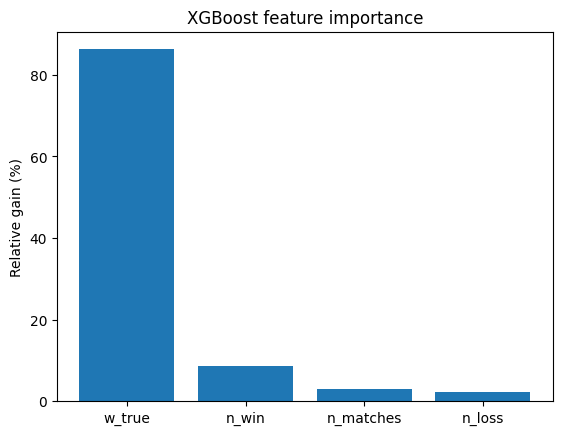

In [99]:
# 0.  (one-time) install if you have not done so
# !pip install xgboost

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# 1.  Assemble the DataFrame exactly as before
# ------------------------------------------------------------------
df = pd.DataFrame({
    "w_true":       w_true_list,
    "w0_solution":  w0_solution_list,
    "n_win":        n_win,
    "n_loss":       n_loss,
    "n_matches":    n_matches       # keep it or drop it—XGBoost handles correlation fine
})

# ------------------------------------------------------------------
# 2.  Train / test split
# ------------------------------------------------------------------
X = df[["w_true", "n_win", "n_loss", "n_matches"]]
y = df["w0_solution"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# ------------------------------------------------------------------
# 3.  A solid default XGBoost model
# ------------------------------------------------------------------
xgb_reg = xgb.XGBRegressor(
    objective      = "reg:squarederror",
    n_estimators   = 500,
    learning_rate  = 0.05,
    max_depth      = 4,
    subsample      = 0.8,
    colsample_bytree = 0.8,
    reg_lambda     = 1.0,
    random_state   = 42,
    n_jobs         = -1
)

xgb_reg.fit(X_train, y_train)

# ------------------------------------------------------------------
# 4.  Evaluation
# ------------------------------------------------------------------
y_pred = xgb_reg.predict(X_test)
print(f"Test R²  : {r2_score(y_test, y_pred):.3f}")
print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")

# ------------------------------------------------------------------
# 5.  Feature importance (gain)
# ------------------------------------------------------------------
booster = xgb_reg.get_booster()
gain = booster.get_score(importance_type="gain")
gain = {k: v / sum(gain.values()) for k, v in gain.items()}   # normalised

# Convert to a sorted list for neat display
imp = sorted(gain.items(), key=lambda t: t[1], reverse=True)
for feat, g in imp:
    print(f"{feat:12s}  {g*100:5.1f}%")

# Optional quick bar-plot (no colour specification per platform rules)
plt.bar([f for f, _ in imp], [g*100 for _, g in imp])
plt.ylabel("Relative gain (%)")
plt.title("XGBoost feature importance")
plt.show()


In [100]:
param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

search = GridSearchCV(
    xgb.XGBRegressor(
        objective="reg:squarederror",
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=42
    ),
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=1
)

search.fit(X, y)
print("Best params :", search.best_params_)
print("Best CV RMSE:", -search.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Best CV RMSE: 0.4874902981545199


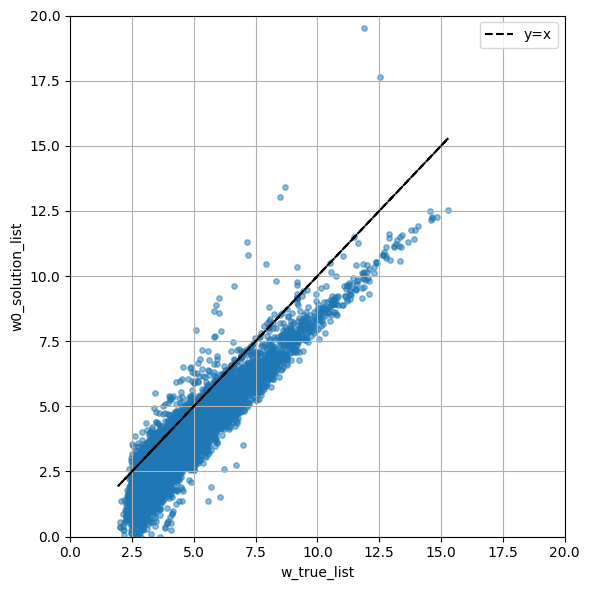

In [109]:

plt.figure(figsize=(6,6))
plt.scatter(np.array(w_true_list) , np.array(w0_solution_list), s=15, alpha=0.5)
# print x=y line
c = np.mean(np.array(w_true_list))
plt.plot(np.array(w_true_list), np.array(w_true_list), color='black', linestyle='--', label='y=x')
W = np.array(w_true_list)
w0 = np.array(w0_solution_list)
# Fit LS W = a * w0 + b
a,b = np.polyfit(w0, W, 1)
# plt.plot( a * np.array(w0_solution_list)**2 + b * np.array(w0_solution_list) + c,np.array(w0_solution_list), color='red', label=f'Fit: y = {a:.2f}x² + {b:.2f}x + {c:.2f}')
# plt.plot(a * np.array(w0_solution_list) + b,w0_solution_list,  color='red', label=f'Fit: y = {a:.2f}x + {b:.2f}')
plt.xlabel('w_true_list')
plt.ylabel('w0_solution_list')
# plt.title('W_true vs w0 (for empty df)')
plt.legend()
plt.grid(True)
# set x lim
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2228688/737430883.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


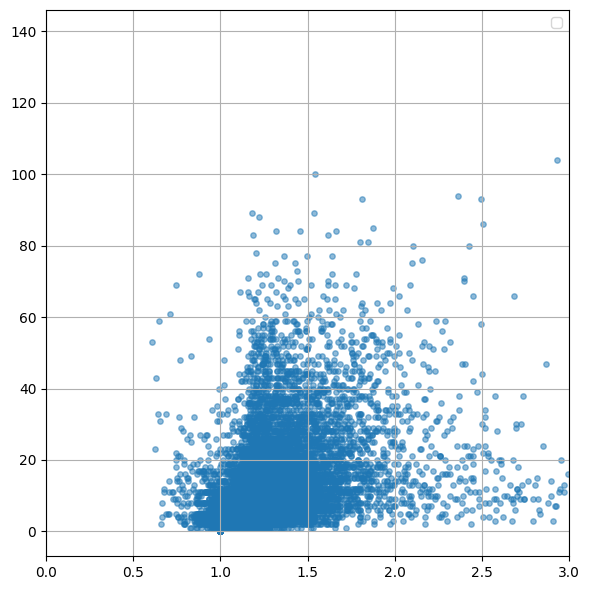

In [ ]:

plt.figure(figsize=(6,6))
plt.scatter(np.array(w_true_list) / np.array(w0_solution_list), n_matches, s=15, alpha=0.5)

W = np.array(w_true_list)
w0 = np.array(w0_solution_list)
# Fit LS W = a * w0 + b
a,b = np.polyfit(w0, W, 1)
# plt.plot( a * np.array(w0_solution_list)**2 + b * np.array(w0_solution_list) + c,np.array(w0_solution_list), color='red', label=f'Fit: y = {a:.2f}x² + {b:.2f}x + {c:.2f}')
# plt.plot(a * np.array(w0_solution_list) + b,w0_solution_list,  color='red', label=f'Fit: y = {a:.2f}x + {b:.2f}')
# plt.xlabel('W_true')
# plt.ylabel('w0')
# plt.title('W_true vs w0 (for empty df)')
plt.legend()
plt.grid(True)
# set x lim
plt.xlim(0, 3)
plt.tight_layout()
plt.show()

In [59]:
comp_values[("Andrin","Wacker")]

9.13223844371773

In [66]:

# 3️⃣ Final pass for **W**, **R**, **C** and absence penalty
records = []
for key, df in player_dfs.items():
    W, R = _compute_W_R(df, w0_map[key], comp_values)
    C = W + R
    # Absence penalty: more than three own forfeits (code "1")
    if len(df)>0 and (df["playerWinnerCode"] == "0").sum() > 3:
        C -= 0.3
    records.append(
        {
            "firstname": key[0],
            "lastname": key[1],
            "W": round(W, 3),
            "R": round(R, 3),
            "C": round(C, 3),
        }
    )

record_df = pd.DataFrame.from_records(records)

In [58]:
record_df[record_df["firstname"] == "Leonard"]

NameError: name 'record_df' is not defined

In [ ]:
w0_map
w0_prev_map
comp_values_players={}
for key in w0_map.keys():
    comp_values_players[key]=(w0_map[key], w0_prev_map[key], player_dfs[key])


In [10]:
comp_values_players[("Leonard","Ung")]

(6.967,
 6.853,
                         adversaryFirstname adversaryLastname playerWinnerCode  \
 date                                                                            
 2025-03-23 00:00:00.000              Ruben         Fernandez                N   
 2025-03-23 00:00:00.000            Olivier         Pifferini                S   
 2025-03-23 00:00:00.000             Adrian            Saliaj                S   
 2024-06-08 15:34:14.249               Luca         Barlocchi                N   
 2024-05-25 12:00:00.000        Carlos José     Cuevas Guzman                N   
 2024-05-11 12:00:00.000             Suriya          Stauffer                S   
 2024-05-05 12:00:00.000               Eric            Borter                N   
 
                         adversary.classification  adversary.competitionValue4L  
 date                                                                            
 2025-03-23 00:00:00.000                       R2                         7.523 

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# assume data = [(W_true_1, w0_1, df_1), (W_true_2, w0_2, df_2), …]
records = []
for W_true, w0, df in comp_values_players.values():
    if df.empty:
        wins = np.array([])
        losses = np.array([])
    else:
        w_vals = df['adversary.competitionValue4L']
        wins = w_vals[df['playerWinnerCode'] == 'S']
        losses = w_vals[df['playerWinnerCode'] == 'N']

    rec = {
        'W_true': W_true,
        'w0': np.exp(w0),
        'w0_minus': np.exp(-w0),
        'sum_win': np.sum(np.exp(wins)),
        'sum_loss': np.sum(np.exp(-losses)),
        'S': len(wins),
        'N': len(losses),
        # extras:
        'log_sum_win': np.log1p(np.sum(np.exp(wins))),
        'log_sum_loss': np.log1p(np.sum(np.exp(-losses))),
        # 'mean_opp': w_vals.mean(),
        # 'std_opp': w_vals.std(),
        # 'win_loss_ratio': np.sum(np.exp(wins)) / (np.sum(np.exp(losses)) + 1e-6),
    }
    records.append(rec)

df_model = pd.DataFrame(records)
X = df_model.drop(columns=['W_true'])
y = df_model['W_true']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1) Random Forest
# rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=0, verbose=1)
# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)
# rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# print(f"RF    RMSE: {rmse_rf:.4f}")

# 2) XGBoost
xgbr = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6, objective='reg:squarederror', random_state=0)
xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgbr.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGB   RMSE: {rmse_xgb:.4f}")

# feature importances
importances = pd.DataFrame({
    'feature': X.columns,
    # 'rf_imp': rf.feature_importances_,
    'xgb_imp': xgbr.feature_importances_
}).sort_values('xgb_imp', ascending=False)
print(importances)


XGB   RMSE: 0.2396
        feature   xgb_imp
1      w0_minus  0.830065
0            w0  0.128542
2       sum_win  0.029905
3      sum_loss  0.006145
4             S  0.004380
5             N  0.000963
6   log_sum_win  0.000000
7  log_sum_loss  0.000000


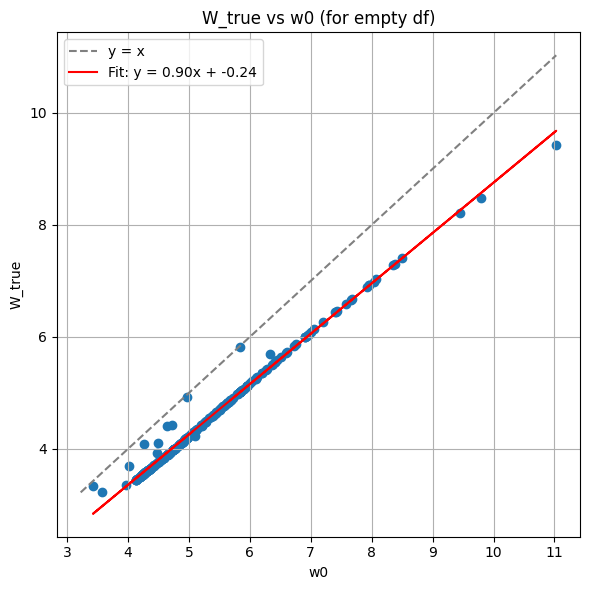

(np.float64(-1.2079226507921704e-16), np.float64(0.10358630272756239))

In [70]:
import matplotlib.pyplot as plt

# Supposons que comp_values_players est déjà défini
w_true_list = []
w0_list = []

for key, (W_true, w0, df) in comp_values_players.items():
    if df.empty:
        if w0 > W_true:
            w_true_list.append(W_true)
            w0_list.append(w0)

# Tracer le graphe
plt.figure(figsize=(6, 6))
plt.scatter(w0_list,w_true_list)
plt.plot([min(w_true_list + w0_list), max(w_true_list + w0_list)],
         [min(w_true_list + w0_list), max(w_true_list + w0_list)],
         linestyle='--', color='gray', label='y = x')  # Ligne de référence
W = np.array(w_true_list)
w0 = np.array(w0_list)
# Fit LS W = a * w0 + b
a,b = np.polyfit(w0, W, 1)
# plt.plot( a * np.array(w0_list)**2 + b * np.array(w0_list) + c,np.array(w0_list), color='red', label=f'Fit: y = {a:.2f}x² + {b:.2f}x + {c:.2f}')
plt.plot(w0_list, a * np.array(w0_list) + b, color='red', label=f'Fit: y = {a:.2f}x + {b:.2f}')
plt.ylabel('W_true')
plt.xlabel('w0')
plt.title('W_true vs w0 (for empty df)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Fit LS W = a * w0 + b

pred = a*w0 + b
err = W - pred
err.mean(), err.std()


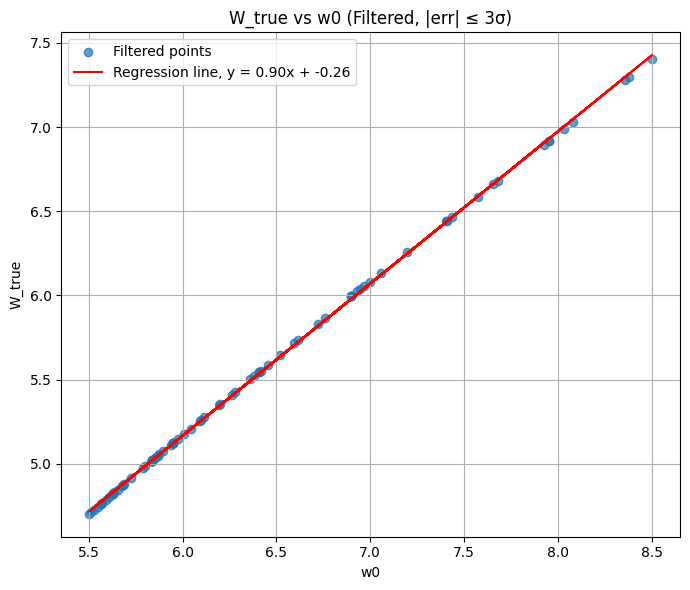

In [59]:
import numpy as np
import matplotlib.pyplot as plt

w_true_list = []
w0_list = []

for key, (W_true, w0, df) in comp_values_players.items():
    if df.empty:
        if w0 > W_true and w0<9 and w0>5.5:
            w_true_list.append(W_true)
            w0_list.append(w0)

# Conversion en tableaux NumPy
W = np.array(w_true_list)
w0 = np.array(w0_list)

# Régression linéaire : W ≈ a*w0 + b
a, b = np.polyfit(w0, W, 1)
pred = a * w0 + b
err = W - pred

# Calcul des statistiques
mean_err = err.mean()
std_err = err.std()

# Filtrage des valeurs dont l'erreur est inférieure ou égale à 3 sigma
mask = np.abs(err) <= 1 * std_err
W_filtered = W[mask]
w0_filtered = w0[mask]

# Nouvelle prédiction pour la droite de régression sur les points filtrés
a, b = np.polyfit(w0_filtered, W_filtered, 1)
pred = a * w0_filtered + b
err = W_filtered - pred
pred_filtered = a * w0_filtered + b

# Tracé
plt.figure(figsize=(7, 6))
plt.scatter(w0_filtered, W_filtered, label='Filtered points', alpha=0.7)
plt.plot(w0_filtered, pred_filtered, color='red', label=f'Regression line, y = {a:.2f}x + {b:.2f}')
plt.xlabel('w0')
plt.ylabel('W_true')
plt.title('W_true vs w0 (Filtered, |err| ≤ 3σ)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
